In [13]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import numpy as np
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executer.memory", "8g")
    .getOrCreate()
)

22/10/08 20:45:22 WARN Utils: Your hostname, DESKTOP-80AOBLL resolves to a loopback address: 127.0.1.1; using 172.23.151.154 instead (on interface eth0)
22/10/08 20:45:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 20:45:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
full = spark.read.parquet('../data/curated/full_data_without_fraud/')
full

user_id,order_datetime,merchant_abn,SA2_code,postcode,consumer_id,state,gender,mean_total_income,dollar_value,order_id,name,tags,revenue_level,take_rate,is_fraud
44,2021-04-09,10648956813,401041015,5074,564558,SA,Undisclosed,53613,68.17405810943993,4d42fd2c-0823-4af...,Proin Nisl Institute,computer,a,6.66,0
44,2021-03-26,16256895427,401041015,5074,564558,SA,Undisclosed,53613,109.29115227377834,20849f6c-9286-4e5...,Tempus Non Founda...,garden supply,a,6.6,0
44,2021-09-03,21702179125,401041015,5074,564558,SA,Undisclosed,53613,128.94839096472307,e2eb1a75-836d-43b...,At Auctor Ullamco...,gift,c,2.65,0
44,2021-09-28,36125151647,401041015,5074,564558,SA,Undisclosed,53613,50.97888666647738,be7da9a9-b31a-4d8...,Sed Nec Corp.,hobby,c,1.83,0
44,2021-10-20,41974958954,401041015,5074,564558,SA,Undisclosed,53613,60.02299315612368,cf13f2cc-5d81-413...,Sed Libero Proin ...,cable,a,5.51,0
44,2021-09-22,41315101616,401041015,5074,564558,SA,Undisclosed,53613,22.01099830027075,784eb5b8-7032-42d...,Malesuada Fames F...,antique,b,5.05,0
44,2021-12-01,49891706470,401041015,5074,564558,SA,Undisclosed,53613,6.1436338479183785,43a40900-af31-421...,Non Vestibulum In...,tent,a,5.8,0
44,2021-11-24,47459279421,401041015,5074,564558,SA,Undisclosed,53613,37.40432919826938,fcba3312-3c72-4e5...,Aliquam Gravida PC,shoe,a,6.86,0
44,2021-07-20,49891706470,401041015,5074,564558,SA,Undisclosed,53613,25.611929292222403,9d3f75e2-f164-42c...,Non Vestibulum In...,tent,a,5.8,0
44,2021-06-29,49891706470,401041015,5074,564558,SA,Undisclosed,53613,9.534770249908876,59ec83dc-bc56-4f0...,Non Vestibulum In...,tent,a,5.8,0


In [6]:
# aggregate the full dataset based on merchant abn and state
full = full.dropDuplicates(['user_id', 'merchant_abn'])
merchant_state = full.groupBy('merchant_abn', 'state').count()

In [7]:
merchant_state = merchant_state.toPandas()
merchant_state.dtypes

merchant_abn     int64
state           object
count            int64
dtype: object

In [8]:
top100 = spark.read.option('header', True).csv('../data/curated/top100.csv')
top100 = top100.toPandas()
top100['merchant_abn'] = top100['merchant_abn'].astype('int')
top100.dtypes

rank                                 object
merchant_abn                          int64
name                                 object
tags                                 object
revenue_level                        object
take_rate                            object
pred_total_num_consumer              object
pred_total_num_transaction           object
pred_total_revenue                   object
scaled_pred_total_num_consumer       object
scaled_pred_total_num_transaction    object
scaled_pred_total_revenue            object
score                                object
segment                              object
dtype: object

In [9]:
# only obtain the consumer state info from top100 merchants
top100_merchant_state = merchant_state[merchant_state['merchant_abn'].isin(top100['merchant_abn'])].reset_index(drop=True)
top100_merchant_state

,merchant_abn,state,count
0,94493496784,WA,3744
1,80324045558,WA,3812
2,81219314324,VIC,4914
3,49212265466,QLD,2756
4,11439466003,NT,242
...,...,...,...
795,60956456424,VIC,5428
796,62694031334,NT,298
797,34179569263,TAS,534
798,20985347699,QLD,3237


In [18]:
# get the number of consumers from state based on top100 merchants
top100_state = top100_merchant_state.groupby('state')['count'].sum()
top100_state = top100_state.to_frame()
top100_state

,count
state,
ACT,16725
NSW,525905
NT,25977
QLD,269547
SA,207297
TAS,67471
VIC,420783
WA,288453


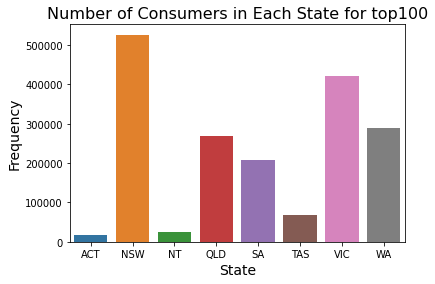

In [21]:
sns.barplot(data=top100_state, x=top100_state.index, y='count')
plt.xlabel('State', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Number of Consumers in Each State for top100', fontsize=16)
plt.savefig('../plots/Consumer distribution for top100.png')
plt.show()